In [15]:
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation
import numpy as np
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt

# Source - https://stackoverflow.com/a/3900167
rcParams.update({'font.size': 14})

---

# Reading the Dataset

In [ ]:
df = pd.read_csv('data/myeloma_data.csv', index_col='ID')
df.head(10)

,Ancestry,PGS_Score,Age,M_Spike,sFLC_Ratio,Creatinine,LP,Time_Months,Status,BMPC_Final,Hgb_Final,PGS_Bin,Clinical_Risk
ID,,,,,,,,,,,,,
1,European,-0.006056,69.111929,3.282018,3.010026,0.522791,2.172474,16.02,1,25.010010,14.598307,Medium PGS,Int Clinical Risk
2,European,0.996723,74.327334,3.468359,3.372553,1.028067,2.034360,0.80,1,NaN,15.478983,Medium PGS,Int Clinical Risk
3,European,0.723133,67.378696,0.588324,2.718493,0.775595,0.134618,107.38,0,0.150430,12.717573,Medium PGS,Low Clinical Risk
4,European,0.821519,72.769428,1.222824,6.164781,0.943936,2.541208,51.56,1,NaN,NaN,Medium PGS,Low Clinical Risk
5,European,-0.806482,64.201009,2.228350,0.438690,0.978404,0.603776,45.18,0,NaN,12.620185,Medium PGS,Int Clinical Risk
6,European,-0.781068,70.892523,0.783407,0.333248,0.989162,-0.449451,110.07,0,6.615842,11.630301,Medium PGS,Low Clinical Risk
7,African American,0.873980,68.354002,0.820777,13.354222,0.824384,0.950020,65.93,1,NaN,13.896251,Medium PGS,Low Clinical Risk
8,European,-0.898449,61.421899,1.264078,28.554619,0.908192,1.861289,85.94,0,NaN,11.944470,Medium PGS,Int Clinical Risk
9,European,1.585733,65.122680,1.084860,1.118959,0.925235,0.790403,13.19,0,16.350008,14.234055,High PGS,Low Clinical Risk


## Encoding Ancestry

In [2]:
print(list(df['Ancestry'].unique())) # ['European', 'African American']

# since there are only 2 ancestry values, we can encode as boolean
df['Ancestry'] = df['Ancestry'].map({
    'European': 1,
    'African American': 0
})
df.head(10)

['European', 'African American']


,Ancestry,PGS_Score,Age,M_Spike,sFLC_Ratio,Creatinine,LP,Time_Months,Status,BMPC_Final,Hgb_Final,PGS_Bin,Clinical_Risk
ID,,,,,,,,,,,,,
1,1,-0.006056,69.111929,3.282018,3.010026,0.522791,2.172474,16.02,1,25.010010,14.598307,Medium PGS,Int Clinical Risk
2,1,0.996723,74.327334,3.468359,3.372553,1.028067,2.034360,0.80,1,NaN,15.478983,Medium PGS,Int Clinical Risk
3,1,0.723133,67.378696,0.588324,2.718493,0.775595,0.134618,107.38,0,0.150430,12.717573,Medium PGS,Low Clinical Risk
4,1,0.821519,72.769428,1.222824,6.164781,0.943936,2.541208,51.56,1,NaN,NaN,Medium PGS,Low Clinical Risk
5,1,-0.806482,64.201009,2.228350,0.438690,0.978404,0.603776,45.18,0,NaN,12.620185,Medium PGS,Int Clinical Risk
6,1,-0.781068,70.892523,0.783407,0.333248,0.989162,-0.449451,110.07,0,6.615842,11.630301,Medium PGS,Low Clinical Risk
7,0,0.873980,68.354002,0.820777,13.354222,0.824384,0.950020,65.93,1,NaN,13.896251,Medium PGS,Low Clinical Risk
8,1,-0.898449,61.421899,1.264078,28.554619,0.908192,1.861289,85.94,0,NaN,11.944470,Medium PGS,Int Clinical Risk
9,1,1.585733,65.122680,1.084860,1.118959,0.925235,0.790403,13.19,0,16.350008,14.234055,High PGS,Low Clinical Risk


## Time To Event

In [3]:
# We use years since it's consistent with PANGEA charts
df['Time_Years'] = df['Time_Months'] / 12

In [7]:
df.isnull().any()

Ancestry         False
PGS_Score        False
Age              False
M_Spike          False
sFLC_Ratio       False
Creatinine       False
LP               False
Time_Months      False
Status           False
BMPC_Final        True
Hgb_Final         True
PGS_Bin          False
Clinical_Risk    False
dtype: bool

---

# Hyperparameter Tuning

The only available hyperparameter in a standard cox model is _alpha_, which regulates how strongly we penalize large coefficients

In [5]:
def scale_standard(df):
    return (df - df.mean(axis=0)) / df.std(axis=0, ddof=0)

# technically we're not allowed to do this with samples that are then used to evaluate the model
# but I'm sure it's ok
def alpha_search(df):
    best_score = .5
    best_alpha = 0
    alpha_grid = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1.0]
    for alpha in alpha_grid:
        cph = CoxPHFitter(alpha=alpha)
        fold_c_scores = k_fold_cross_validation(cph, df, duration_col, event_col, k=5, scoring_method='concordance_index')
        mean_score = np.mean(fold_c_scores)
        print(f'alpha {alpha}: {mean_score}')
        if mean_score >= best_score:
            best_score = mean_score
            best_alpha = alpha
    return best_alpha

standard_lab_cols = [
    'Ancestry', 
    'Age', 
    'M_Spike', 
    'sFLC_Ratio', 
    'Creatinine', 
]
duration_col = 'Time_Years'
event_col = 'Status'
output_df = df[[duration_col, event_col]]
dfx = scale_standard(df[standard_lab_cols]).join(output_df)
optimal = alpha_search(dfx)
print(f'optimal alpha: {optimal}')

alpha 0.0001: 0.6885657405032026
alpha 0.001: 0.687700949472697
alpha 0.01: 0.6874781039082178
alpha 0.05: 0.6894234138102939
alpha 0.1: 0.6864646146111222
alpha 0.2: 0.6879526794384214
alpha 0.5: 0.684660353150439
alpha 0.8: 0.6892777859154743
alpha 1.0: 0.6862958615609702
optimal alpha: 0.05


We can see that alpha doesn't make a significant difference.
According to the [docs](https://lifelines.readthedocs.io/en/latest/fitters/regression/CoxPHFitter.html#lifelines.fitters.coxph_fitter.CoxPHFitter), lifelines actually already uses `0.05` as the default alpha value, so we'll just leave it like that.

---

# Feature Evaluation

In [19]:
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation
import numpy as np

standard_lab_cols = [
    'Ancestry', 
    'Age', 
    'M_Spike', 
    'sFLC_Ratio', 
    'Creatinine', 
]
duration_col = 'Time_Years'
event_col = 'Status'

def evaluate_model(df):
    
    # 26% is way too high
    # Kyle et al. 2018 -> should be ~10%
    # THIS is the reason why progression predictions are unreasonably high
    print(f"{len(df.index)} probands of which {100*df[event_col].sum() / len(df.index):.0f}% MM progression")

    cph = CoxPHFitter()
    k = 5
    fold_c_scores = k_fold_cross_validation(cph, df, duration_col, event_col, k=k, scoring_method='concordance_index')
    mean_c = np.mean(fold_c_scores)
    print(f"{k}-fold-validation calculated mean c index of {mean_c:.4f}")
    return mean_c

print('LAB VALS')
dfx = df[standard_lab_cols+[duration_col, event_col]]
LAB = evaluate_model(dfx)
print()

print('LAB VALS + PGS SCORE')
dfx = df[standard_lab_cols+['PGS_Score', duration_col, event_col]]
LAB_PGS = evaluate_model(dfx)
print()

print('LAB VALS + BONE MARROW / HEMOGLOBIN')
dfx = df[standard_lab_cols+['BMPC_Final', 'Hgb_Final', duration_col, event_col]]
dfx = dfx[dfx[['BMPC_Final', 'Hgb_Final']].notnull().all(axis=1)]
LAB_BM = evaluate_model(dfx)
print()

print('LAB VALS + PGS SCORE + BONE MARROW / HEMOGLOBIN')
dfx = df[standard_lab_cols+['BMPC_Final', 'Hgb_Final', 'PGS_Score', duration_col, event_col]]
dfx = dfx[dfx[['BMPC_Final', 'Hgb_Final']].notnull().all(axis=1)]
LAB_PGS_BM = evaluate_model(dfx)

LAB VALS
2000 probands of which 26% MM progression
5-fold-validation calculated mean c index of 0.6872

LAB VALS + PGS SCORE
2000 probands of which 26% MM progression
5-fold-validation calculated mean c index of 0.7070

LAB VALS + BONE MARROW / HEMOGLOBIN
1173 probands of which 26% MM progression
5-fold-validation calculated mean c index of 0.7009

LAB VALS + PGS SCORE + BONE MARROW / HEMOGLOBIN
1173 probands of which 26% MM progression
5-fold-validation calculated mean c index of 0.7195


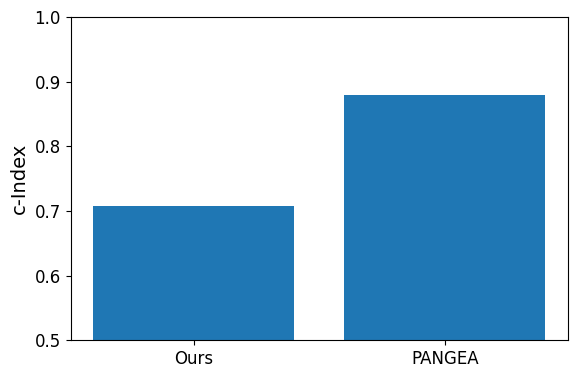

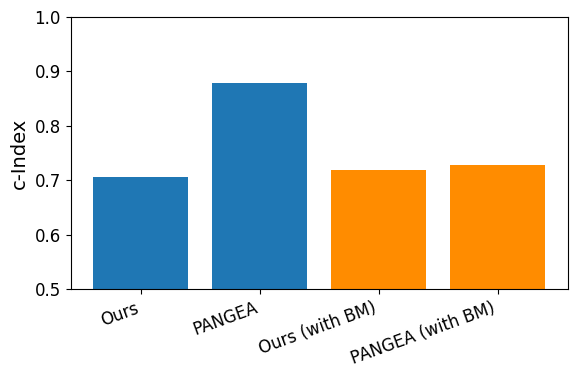

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

PANGEA = 0.879
PANGEA_BM = 0.729

df_no_bm = pd.DataFrame([
    {'name': 'Ours', 'score': LAB_PGS},
    {'name': 'PANGEA', 'score': PANGEA},
])

df_bm = pd.DataFrame([
    {'name': 'Ours', 'score': LAB_PGS},
    {'name': 'PANGEA', 'score': PANGEA},
    {'name': 'Ours (with BM)', 'score': LAB_PGS_BM},
    {'name': 'PANGEA (with BM)', 'score': PANGEA_BM},
])

def plot(df, rotation=0):
    plt.figure(figsize=(6, 4))

    colors = ['darkorange' if 'BM' in name else 'C0' for name in df['name']]
    plt.bar(df['name'], df['score'], color=colors)

    plt.ylim(0.5, 1.0)
    plt.ylabel('c-Index', fontsize=14)
    plt.xticks(fontsize=12, rotation=rotation, ha='right' if rotation else 'center')
    plt.yticks(fontsize=12)

    plt.tight_layout()
    plt.show()

plot(df_no_bm)
plot(df_bm, rotation=20)

---

# Individual Prediction With Bootstrapping

C:\Users\Jan\AppData\Local\Temp\ipykernel_22424\2127178696.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


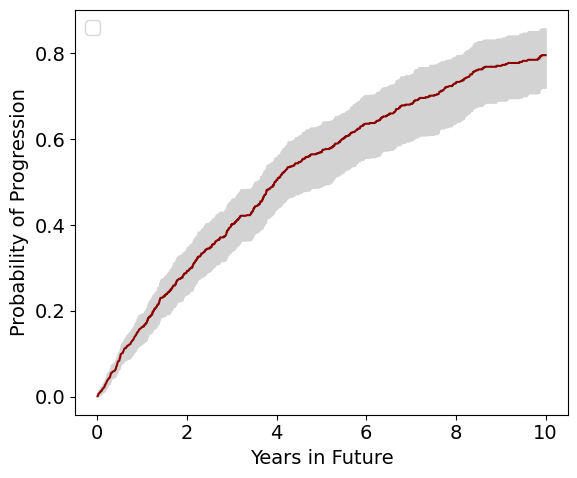

In [26]:
# -----------------------
# Configuration
# -----------------------
test_patient = pd.Series({
    'Ancestry': 1, # European
    'Age': 65, 
    'M_Spike': 3.2, 
    'sFLC_Ratio': 1.5, 
    'Creatinine': 1.2, 
})
B = 100  # number of bootstrap samples
alpha = 0.05

# just use the lab values for prediction, like in PANGEA (no BM)
cols = standard_lab_cols + [duration_col, event_col]

# Fit once to get time grid
cph = CoxPHFitter()
cph.fit(df[cols], duration_col=duration_col, event_col=event_col)

times = cph.baseline_survival_.index

surv_boot = []

for b in range(B):
    boot_df = df.sample(frac=1, replace=True)

    cph_b = CoxPHFitter()
    cph_b.fit(
        boot_df[cols],
        duration_col=duration_col,
        event_col=event_col
    )

    s = cph_b.predict_survival_function(
        test_patient,
        times=times
    )

    # convert to cumulative incidence
    surv_boot.append(1 - s.values.flatten())

surv_boot = np.array(surv_boot)

# Point estimate from original model
surv_hat = cph.predict_survival_function(
    test_patient,
    times=times
)
cum_hat = 1 - surv_hat.iloc[:, 0].values

# Bootstrap CI
lower = np.percentile(surv_boot, 100 * alpha / 2, axis=0)
upper = np.percentile(surv_boot, 100 * (1 - alpha / 2), axis=0)

plt.figure(figsize=(6, 5))

plt.fill_between(
    times,
    lower,
    upper,
    color='lightgrey',
    # label=f"{int((1-alpha)*100)}% bootstrap CI"
)
plt.plot(
    times, 
    cum_hat, 
    # label="Estimated progression risk", 
    color='darkred'
)

plt.xlabel("Years in Future")
plt.ylabel("Probability of Progression")
plt.legend()
plt.tight_layout()
plt.show()


---

# Kaplan Meier Chart

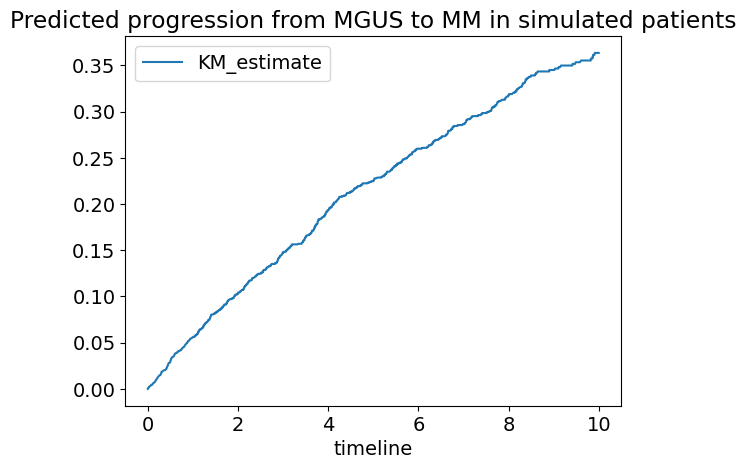

In [18]:
# https://lifelines.readthedocs.io/en/latest/Survival%20analysis%20with%20lifelines.html

from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf.fit(df[duration_col], event_observed=df[event_col])

from matplotlib import pyplot as plt

(1-kmf.survival_function_).plot()
plt.title('Predicted progression from MGUS to MM in simulated patients');